<a href="https://colab.research.google.com/github/ulkuhos/Deep-Learning-with-Time-Series/blob/main/Midterm_Project_MLP_RBF_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# Veri işleme
import pandas as pd
import numpy as np

# Model oluşturma ve değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
# Gerekli PyTorch modüllerini ekleme
from torchvision import datasets, transforms

# Veri setini indirip yükleme (eğitim ve test setleri)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Veriyi normalize et
])

# Eğitim ve test setleri
train_data = datasets.GTSRB(root='./data', split='train', transform=transform, download=True)
test_data = datasets.GTSRB(root='./data', split='test', transform=transform, download=True)

# Veri seti boyutlarını kontrol et
print(f"Eğitim verisi boyutu: {len(train_data)}")
print(f"Test verisi boyutu: {len(test_data)}")


100%|██████████| 187M/187M [00:07<00:00, 25.8MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:04<00:00, 21.2MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 234kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb
Eğitim verisi boyutu: 26640
Test verisi boyutu: 12630


In [3]:
# Gerekli kütüphaneler
from torchvision.transforms import functional as F

# Eğitim setindeki görüntüleri numpy formatına dönüştürme ve yeniden boyutlandırma
X_train = np.array([F.resize(img[0], (32, 32)).numpy().flatten() for img in train_data])
y_train = np.array([img[1] for img in train_data])

# Test setindeki görüntüleri numpy formatına dönüştürme ve yeniden boyutlandırma
X_test = np.array([F.resize(img[0], (32, 32)).numpy().flatten() for img in test_data])
y_test = np.array([img[1] for img in test_data])

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri başarıyla ölçeklendirildi.")
print(f"Ölçeklendirilmiş eğitim verisi boyutu: {X_train_scaled.shape}")
print(f"Ölçeklendirilmiş test verisi boyutu: {X_test_scaled.shape}")


Veri başarıyla ölçeklendirildi.
Ölçeklendirilmiş eğitim verisi boyutu: (26640, 3072)
Ölçeklendirilmiş test verisi boyutu: (12630, 3072)


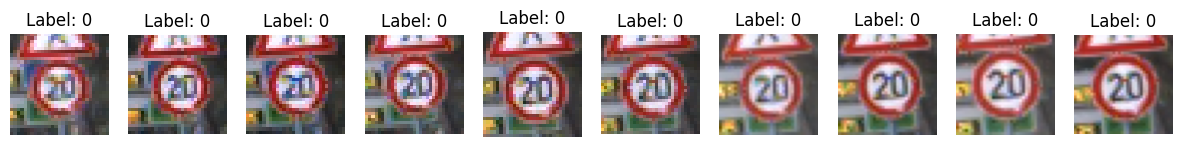

In [4]:
# Eğitim veri setinden birkaç örneği görselleştirme
import matplotlib.pyplot as plt

# Görüntülerin ilk 10 tanesini görselleştirme
# Görsellerin normalize edilmiş değerlerini [0, 1] aralığına çekerek düzeltiyoruz
fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # 1 satır, 5 sütun
for i, ax in enumerate(axes):
   # Görüntüyü yeniden boyutlandır ve normalize etmeden göster
    img = train_data[i][0].permute(1, 2, 0).numpy()  # Tensörü numpy array'e çevir. # Görüntüyü (H, W, C) formatına çevir
    img = (img - img.min()) / (img.max() - img.min())  # Görseli 0-1 aralığına döndür
    ax.imshow(img)  # Görüntüyü göster
    ax.set_title(f"Label: {train_data[i][1]}")  # Etiket ekle
    ax.axis('off')  # Eksenleri kapat
plt.show()


In [5]:
# Etiketlerin dağılımını kontrol etme
import numpy as np
labels = [train_data[i][1] for i in range(len(train_data))]
unique, counts = np.unique(labels, return_counts=True)

print("Sınıf dağılımı:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} örnek")

Sınıf dağılımı:
Label 0: 150 örnek
Label 1: 1500 örnek
Label 2: 1500 örnek
Label 3: 960 örnek
Label 4: 1320 örnek
Label 5: 1260 örnek
Label 6: 300 örnek
Label 7: 960 örnek
Label 8: 960 örnek
Label 9: 990 örnek
Label 10: 1350 örnek
Label 11: 900 örnek
Label 12: 1410 örnek
Label 13: 1440 örnek
Label 14: 540 örnek
Label 15: 420 örnek
Label 16: 300 örnek
Label 17: 750 örnek
Label 18: 810 örnek
Label 19: 150 örnek
Label 20: 240 örnek
Label 21: 240 örnek
Label 22: 270 örnek
Label 23: 360 örnek
Label 24: 180 örnek
Label 25: 1020 örnek
Label 26: 420 örnek
Label 27: 180 örnek
Label 28: 360 örnek
Label 29: 180 örnek
Label 30: 300 örnek
Label 31: 540 örnek
Label 32: 180 örnek
Label 33: 480 örnek
Label 34: 300 örnek
Label 35: 810 örnek
Label 36: 270 örnek
Label 37: 150 örnek
Label 38: 1380 örnek
Label 39: 210 örnek
Label 40: 240 örnek
Label 41: 180 örnek
Label 42: 180 örnek


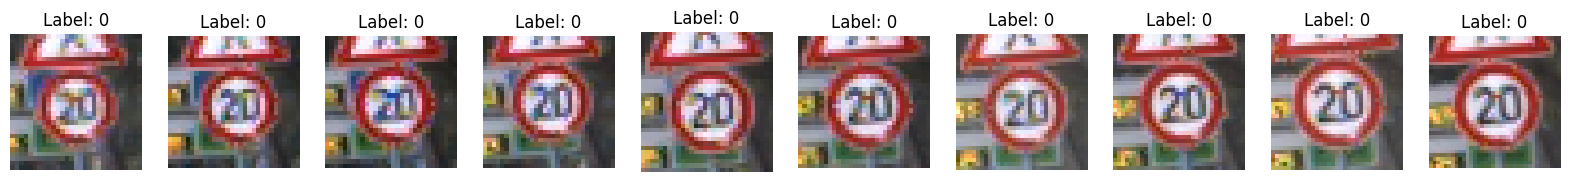

In [96]:
# İlk 10 görüntüyü etiketlerle görselleştirme
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axes):
    img = train_data[i][0].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(f"Label: {train_data[i][1]}")
    ax.axis('off')
plt.show()


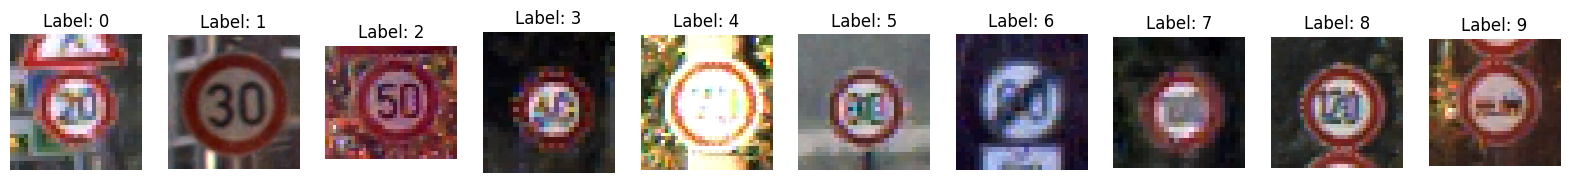

In [7]:
# Farklı 10 sınıftan birer örnek seçip görselleştirme
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
unique_labels = set()
i = 0

for img, label in train_data:
    if label not in unique_labels:
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
        unique_labels.add(label)
        i += 1
    if i == 10:  # 10 farklı sınıfı görselleştir
        break
plt.show()


#### 1- MLP MODELLERİ

Gerekli kütüphaneler ve kurumları

MLP Modeli Model 1:

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp_model1 = MLPClassifier(
    max_iter=100,  # 100 epoch
    batch_size=16,  # Her iterasyonda 16 örnek
    random_state=42
)
mlp_model1.fit(X_train_scaled, y_train)

y_pred_model1 = mlp_model1.predict(X_test_scaled)
print("Model 1 - Performans (Düşük Epoch ve Küçük Batch Size)")
print(classification_report(y_test, y_pred_model1))



Model 1 - Performans (Düşük Epoch ve Küçük Batch Size)
              precision    recall  f1-score   support

           0       0.62      0.35      0.45        60
           1       0.75      0.89      0.82       720
           2       0.84      0.83      0.84       750
           3       0.74      0.64      0.69       450
           4       0.80      0.73      0.76       660
           5       0.62      0.90      0.74       630
           6       0.82      0.79      0.80       150
           7       0.79      0.73      0.76       450
           8       0.76      0.80      0.78       450
           9       0.89      0.82      0.86       480
          10       0.91      0.96      0.93       660
          11       0.79      0.87      0.83       420
          12       0.96      0.95      0.96       690
          13       0.99      0.97      0.98       720
          14       0.99      0.87      0.93       270
          15       0.93      0.77      0.84       210
          16       0.94   

MLP Modeli Model 1: Kayıp değerleri grafiği

Modelin son kayıp değeri: 0.21858553093261276


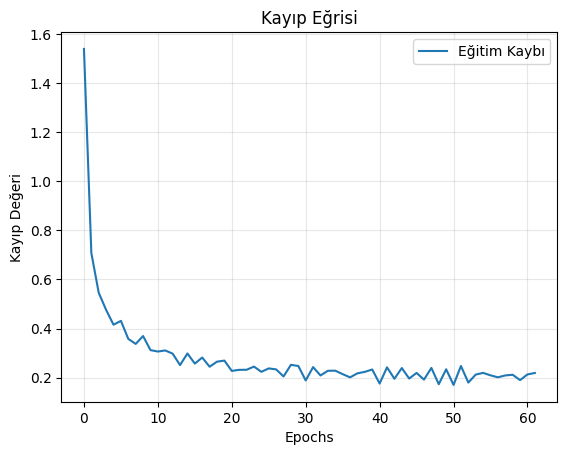

In [31]:
# Model eğitimi sırasında kaydedilen kayıp eğrisi
loss_values = mlp_model1.loss_curve_

# Son kayıp değeri
final_loss = loss_values[-1]  # Son epoch'taki kayıp değeri
print(f"Modelin son kayıp değeri: {final_loss}")

# Tüm kayıp değerlerini görselleştirme
import matplotlib.pyplot as plt
plt.plot(loss_values, label="Eğitim Kaybı")
plt.title("Kayıp Eğrisi")
plt.xlabel("Epochs")
plt.ylabel("Kayıp Değeri")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


MLP Modeli Model 2:

In [32]:
mlp_model2 = MLPClassifier(
    hidden_layer_sizes=(30, 30),  # İki katman, her biri 30 nöron
    max_iter=150,  # 150 epoch
    batch_size=32,  # Her iterasyonda 32 örnek
    learning_rate_init=0.01,  # Öğrenme oranı 0.01
    random_state=42
)
mlp_model2.fit(X_train_scaled, y_train)

y_pred_model2 = mlp_model2.predict(X_test_scaled)
print("Model 2 - Performans (Düşük Oranlarla)")
print(classification_report(y_test, y_pred_model2))



Model 2 - Performans (Düşük Oranlarla)
              precision    recall  f1-score   support

           0       0.04      0.32      0.07        60
           1       0.00      0.00      0.00       720
           2       0.24      0.39      0.30       750
           3       0.07      0.00      0.00       450
           4       0.25      0.00      0.00       660
           5       0.26      0.17      0.21       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.46      0.16      0.24       480
          10       0.09      0.86      0.16       660
          11       0.95      0.30      0.46       420
          12       1.00      0.23      0.37       690
          13       0.77      0.59      0.67       720
          14       1.00      0.03      0.06       270
          15       0.20      0.00      0.01       210
          16       0.27      0.49      0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP Modeli Model 2: Kayıp değerleri grafiği

Modelin son kayıp değeri: 1.8955517240650022


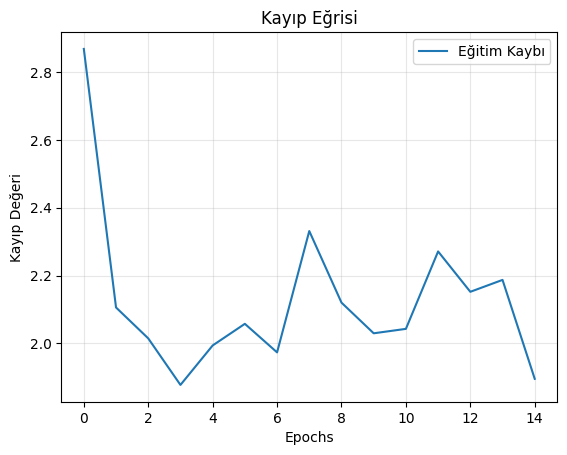

In [33]:
# Model eğitimi sırasında kaydedilen kayıp eğrisi
loss_values = mlp_model2.loss_curve_

# Son kayıp değeri
final_loss = loss_values[-1]  # Son epoch'taki kayıp değeri
print(f"Modelin son kayıp değeri: {final_loss}")

# Tüm kayıp değerlerini görselleştirme
import matplotlib.pyplot as plt
plt.plot(loss_values, label="Eğitim Kaybı")
plt.title("Kayıp Eğrisi")
plt.xlabel("Epochs")
plt.ylabel("Kayıp Değeri")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


MLP Modeli Model 3:

In [12]:
mlp_model3 = MLPClassifier(
    hidden_layer_sizes=(50,),  # Tek katman, 50 nöron
    max_iter=200,  # 200 epoch
    batch_size=64,  # Her iterasyonda 64 örnek
    activation='logistic',  # Sigmoid aktivasyon fonksiyonu
    learning_rate_init=0.005,  # Öğrenme oranı 0.005
    random_state=42
)
mlp_model3.fit(X_train_scaled, y_train)

y_pred_model3 = mlp_model3.predict(X_test_scaled)
print("Model 3 - Performans (Aktivasyon Fonksiyonunu Değiştiren)")
print(classification_report(y_test, y_pred_model3))



Model 3 - Performans (Aktivasyon Fonksiyonunu Değiştiren)
              precision    recall  f1-score   support

           0       0.20      0.02      0.03        60
           1       0.72      0.86      0.78       720
           2       0.74      0.85      0.79       750
           3       0.78      0.75      0.76       450
           4       0.77      0.79      0.78       660
           5       0.72      0.69      0.71       630
           6       0.76      0.72      0.74       150
           7       0.76      0.76      0.76       450
           8       0.77      0.72      0.75       450
           9       0.89      0.93      0.91       480
          10       0.87      0.93      0.90       660
          11       0.76      0.80      0.78       420
          12       0.93      0.93      0.93       690
          13       0.93      0.98      0.96       720
          14       0.92      0.71      0.81       270
          15       0.77      0.85      0.81       210
          16       0.84

MLP Modeli Model 3: Kayıp değerleri grafiği

Modelin son kayıp değeri: 0.36226708054038453


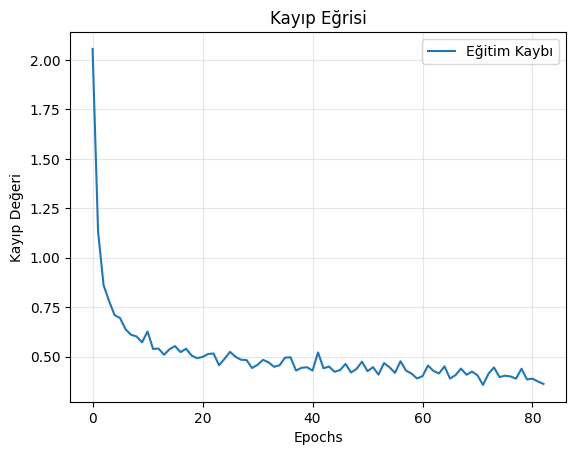

In [34]:
# Model eğitimi sırasında kaydedilen kayıp eğrisi
loss_values = mlp_model3.loss_curve_

# Son kayıp değeri
final_loss = loss_values[-1]  # Son epoch'taki kayıp değeri
print(f"Modelin son kayıp değeri: {final_loss}")

# Tüm kayıp değerlerini görselleştirme
import matplotlib.pyplot as plt
plt.plot(loss_values, label="Eğitim Kaybı")
plt.title("Kayıp Eğrisi")
plt.xlabel("Epochs")
plt.ylabel("Kayıp Değeri")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


MLP Modeli Model 4:

In [14]:
mlp_model4 = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # İki katman: 64 ve 32 nöron
    max_iter=250,  # 250 epoch
    batch_size=32,  # Her iterasyonda 32 örnek işlenecek
    learning_rate_init=0.002,  # Daha düşük öğrenme oranı
    random_state=42
)
mlp_model4.fit(X_train_scaled, y_train)

y_pred_model4 = mlp_model4.predict(X_test_scaled)
print("Model 4 - Performans (Düşük Öğrenme Oranı)")
print(classification_report(y_test, y_pred_model4))



Model 4 - Performans (Düşük Öğrenme Oranı)
              precision    recall  f1-score   support

           0       0.95      0.65      0.77        60
           1       0.91      0.76      0.83       720
           2       0.71      0.93      0.80       750
           3       0.74      0.76      0.75       450
           4       0.82      0.75      0.78       660
           5       0.65      0.78      0.71       630
           6       0.87      0.77      0.82       150
           7       0.92      0.73      0.81       450
           8       0.74      0.72      0.73       450
           9       0.85      0.91      0.88       480
          10       0.95      0.90      0.93       660
          11       0.78      0.92      0.84       420
          12       0.94      0.93      0.93       690
          13       0.98      0.97      0.97       720
          14       0.96      0.80      0.87       270
          15       0.77      0.94      0.85       210
          16       0.93      0.91     

MLP Modeli Model 4: Kayıp değerleri grafiği

Modelin son kayıp değeri: 0.20933306429647502


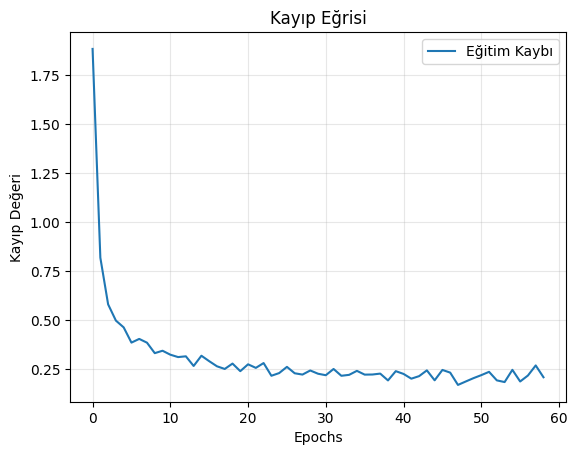

In [15]:
# Model eğitimi sırasında kaydedilen kayıp eğrisi
loss_values = mlp_model4.loss_curve_

# Son kayıp değeri
final_loss = loss_values[-1]  # Son epoch'taki kayıp değeri
print(f"Modelin son kayıp değeri: {final_loss}")

# Tüm kayıp değerlerini görselleştirme
import matplotlib.pyplot as plt
plt.plot(loss_values, label="Eğitim Kaybı")
plt.title("Kayıp Eğrisi")
plt.xlabel("Epochs")
plt.ylabel("Kayıp Değeri")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### 4 MLP Modelinin hepsi bir yerde karışıklık matriksleri:


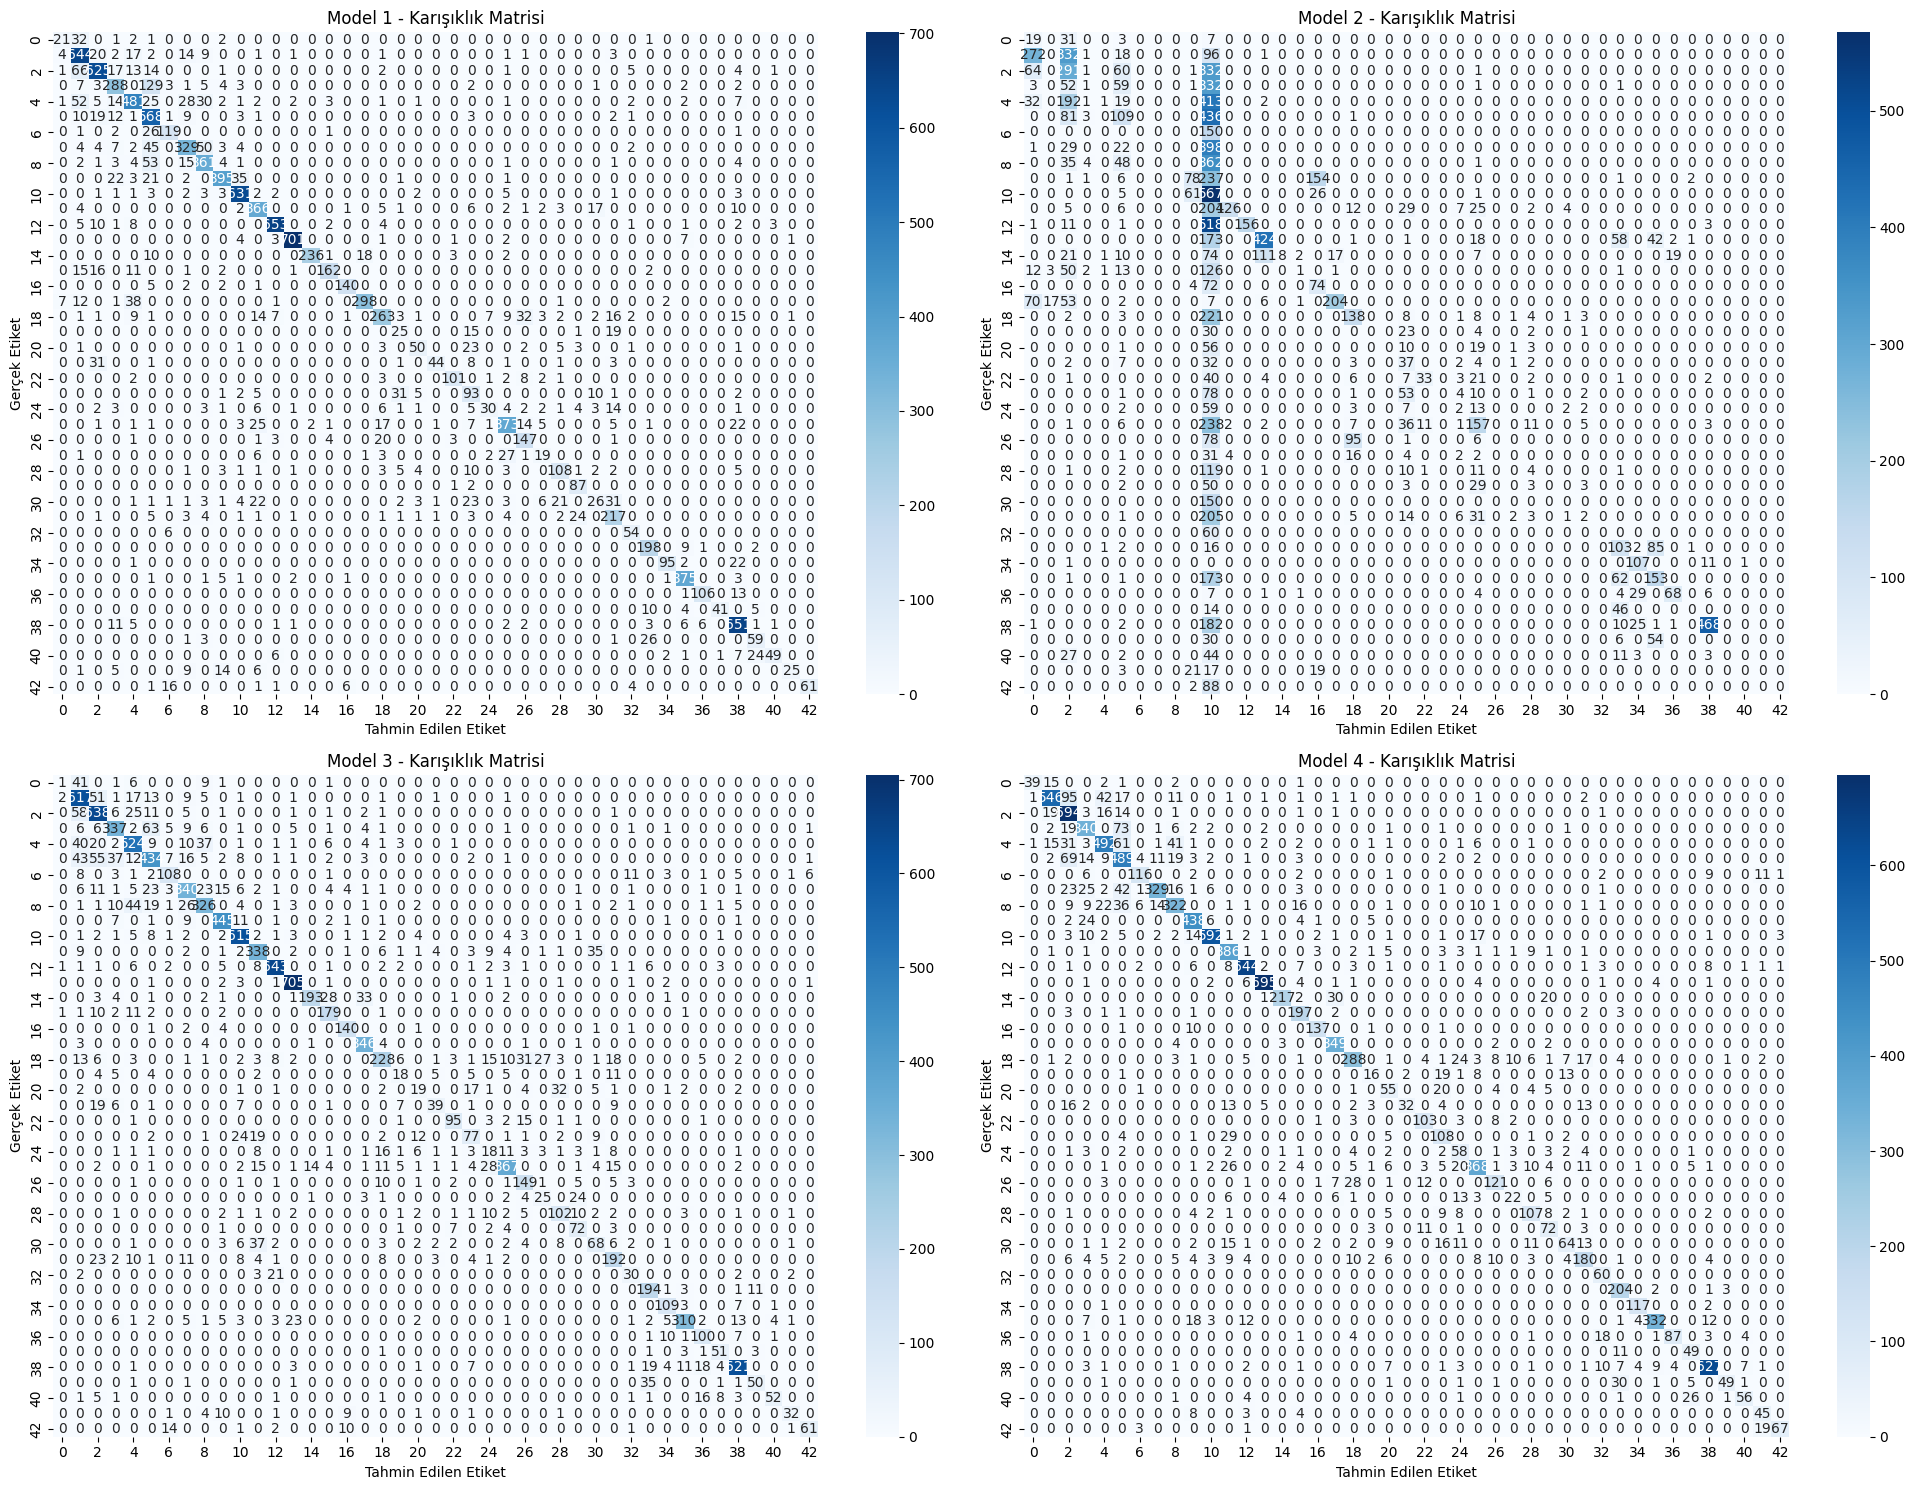

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dört model için karışıklık matrislerini görselleştirme
def plot_all_confusion_matrices(y_test, preds, model_names):
    plt.figure(figsize=(20, 15))  # Grafik boyutlarını ayarla

    for i, (y_pred, model_name) in enumerate(zip(preds, model_names), 1):
        cm = confusion_matrix(y_test, y_pred)
        plt.subplot(2, 2, i)  # 2x2 grid şeklinde her bir modeli yerleştir
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{model_name} - Karışıklık Matrisi")
        plt.xlabel("Tahmin Edilen Etiket")
        plt.ylabel("Gerçek Etiket")

    plt.tight_layout()
    plt.show()

# Tahmin sonuçları ve model isimleri
preds = [y_pred_model1, y_pred_model2, y_pred_model3, y_pred_model4]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]

# Fonksiyonu çağırma
plot_all_confusion_matrices(y_test, preds, model_names)


#### 4 MLP Modelinin sonuçlarına ait performans grafiği:

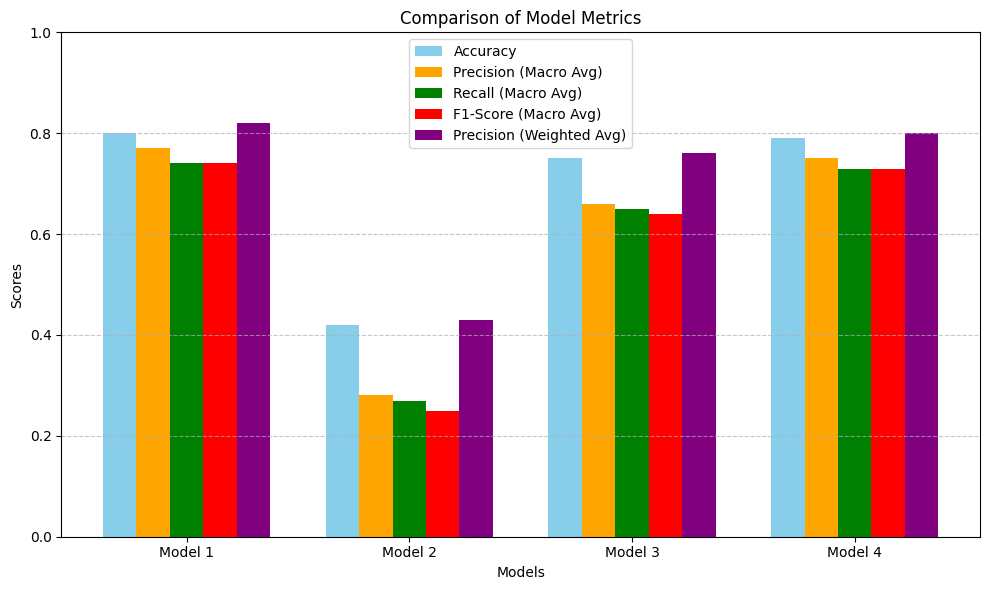

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Modellerin sonuçları
models = ["Model 1", "Model 2", "Model 3", "Model 4"]
accuracy = [0.80, 0.42, 0.75, 0.79]
precision_macro = [0.77, 0.28, 0.66, 0.75]
recall_macro = [0.74, 0.27, 0.65, 0.73]
f1_macro = [0.74, 0.25, 0.64, 0.73]
precision_weighted = [0.82, 0.43, 0.76, 0.80]

# Grafik oluşturma
x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))

# Her metriği yan yana çubuklarla gösterme
ax.bar(x - 2*width, accuracy, width, label="Accuracy", color="skyblue")
ax.bar(x - width, precision_macro, width, label="Precision (Macro Avg)", color="orange")
ax.bar(x, recall_macro, width, label="Recall (Macro Avg)", color="green")
ax.bar(x + width, f1_macro, width, label="F1-Score (Macro Avg)", color="red")
ax.bar(x + 2*width, precision_weighted, width, label="Precision (Weighted Avg)", color="purple")

# Ayarlar
ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Metrics")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc="best")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Grafiği gösterme
plt.show()


#### 2- RBF MODELLERİ

Gerekli kütüphaneler ve kurumları

In [69]:
# Gerekli kütüphaneler
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# RBF Katmanı (Gaussian Aktivasyon Fonksiyonu ile)
class RBFLayer(Layer):
    def __init__(self, units, betas=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.betas = betas

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='random_normal',
            trainable=True
        )
        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(self.betas),
            trainable=True
        )

    def call(self, inputs):
        c = tf.expand_dims(self.centers, axis=0)
        x = tf.expand_dims(inputs, axis=1)
        return tf.exp(-self.betas * tf.reduce_sum(tf.square(x - c), axis=2))

# Eğitim verilerinin giriş boyutunu belirleme
input_dim = X_train_scaled.shape[1]

RBF Modeli Model 1:

In [19]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

# Hedef değişkenleri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# RBF Model 1
model1 = Sequential()
model1.add(Dense(10, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # RBF katman
model1.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history1 = model1.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy = model1.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy[1]}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0513 - loss: 3.6834 - val_accuracy: 0.0607 - val_loss: 3.5488
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0581 - loss: 3.5410 - val_accuracy: 0.0635 - val_loss: 3.4936
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0576 - loss: 3.5066 - val_accuracy: 0.0603 - val_loss: 3.4747
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0553 - loss: 3.4974 - val_accuracy: 0.0547 - val_loss: 3.4703
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0567 - loss: 3.4975 - val_accuracy: 0.0584 - val_loss: 3.4661
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0557 - loss: 3.4992 - val_accuracy: 0.0591 - val_loss: 3.4660
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0589 - loss: 3.4968 - val_accuracy: 0.0573 - val_loss: 3.4649
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0571 - loss: 3.4973 - val_accuracy: 0.

In [88]:
import numpy as np

# Tahmin edilen değerleri (y_pred) hesaplama
y_pred = model1.predict(X_test_scaled)  # Modelin test verileri üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Her sınıf için en yüksek olasılığa sahip etiketi alır

# Gerçek değerleri (y_true) işleme
y_true = np.argmax(y_test_encoded, axis=1)  # Gerçek etiketleri one-hot encoding'den çıkarır

# y_pred ve y_true çıktısı
print("Tahmin Edilen Değerler (y_pred):", y_pred_classes)
print("Gerçek Değerler (y_true):", y_true)


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tahmin Edilen Değerler (y_pred): [2 2 2 ... 2 2 2]
Gerçek Değerler (y_true): [16  1 38 ...  6  7 10]


RBF Modeli Model 1: Karışıklık Matrisi

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


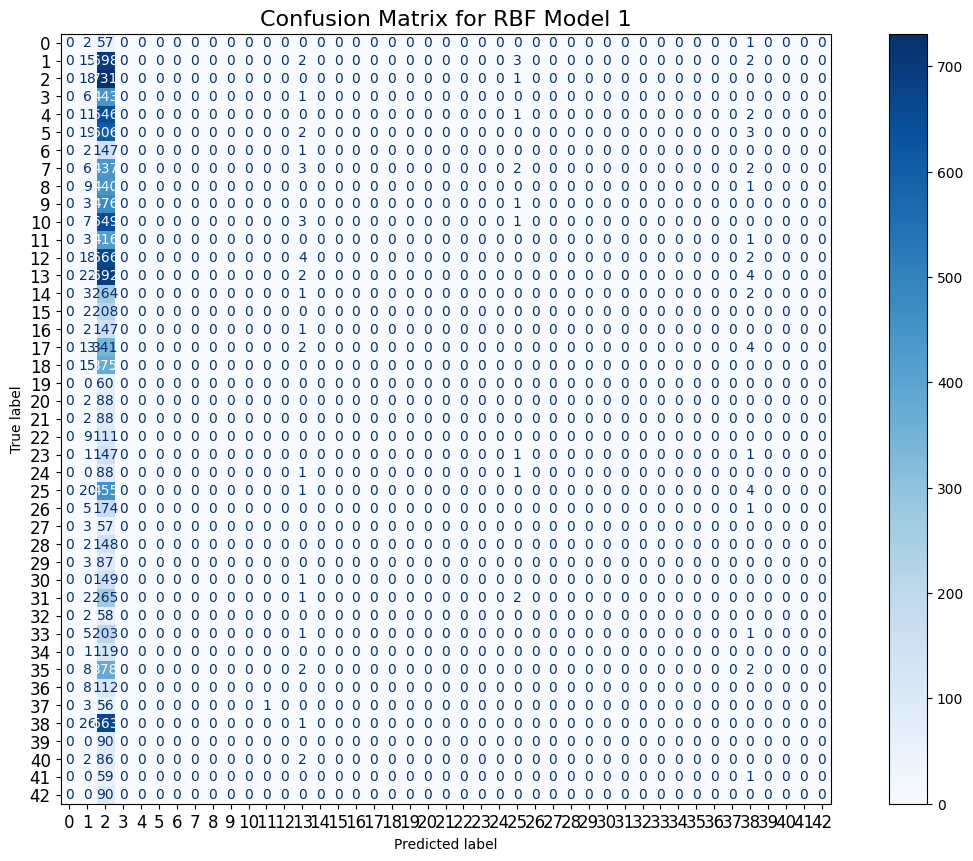

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred_encoded = model1.predict(X_test_scaled)  # Model tahminleri
y_pred = np.argmax(y_pred_encoded, axis=1)      # One-hot'dan sınıf etiketi olarak dönüştür
y_true = np.argmax(y_test_encoded, axis=1)      # Gerçek etiketleri one-hot'dan çıkar

# Karışıklık matrisi oluştur
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(15, 10))  # Yükseklik küçültüldü
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # `ax` ile mevcut ekseni kullanıyoruz
plt.title("Confusion Matrix for RBF Model 1", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


RBF Modeli Model 1: Performans grafikleri

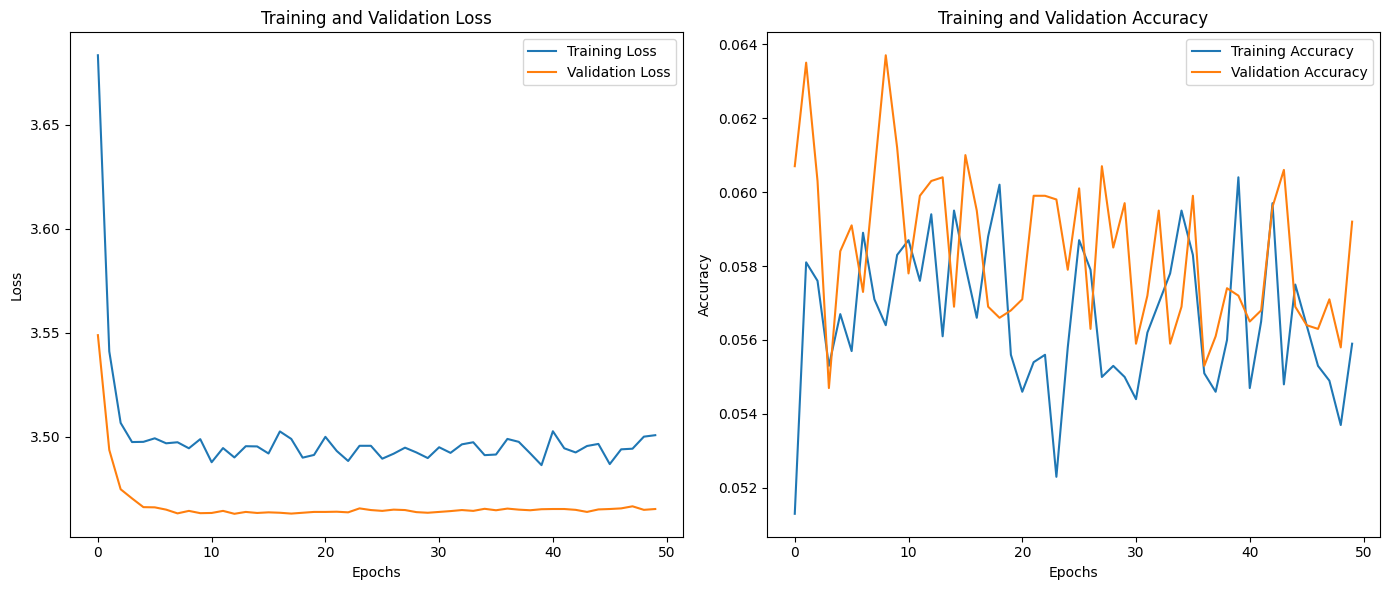

In [70]:
import matplotlib.pyplot as plt

# Modelin sonuçları
loss = [
    3.6834, 3.5410, 3.5066, 3.4974, 3.4975, 3.4992, 3.4968, 3.4973, 3.4944, 3.4988,
    3.4877, 3.4945, 3.4900, 3.4954, 3.4953, 3.4919, 3.5025, 3.4989, 3.4899, 3.4912,
    3.4999, 3.4931, 3.4883, 3.4956, 3.4956, 3.4894, 3.4918, 3.4947, 3.4924, 3.4897,
    3.4949, 3.4922, 3.4963, 3.4973, 3.4911, 3.4914, 3.4989, 3.4975, 3.4920, 3.4863,
    3.5026, 3.4944, 3.4924, 3.4955, 3.4965, 3.4868, 3.4939, 3.4942, 3.5000, 3.5007
]
val_loss = [
    3.5488, 3.4936, 3.4747, 3.4703, 3.4661, 3.4660, 3.4649, 3.4631, 3.4643, 3.4632,
    3.4633, 3.4643, 3.4629, 3.4638, 3.4633, 3.4636, 3.4634, 3.4630, 3.4634, 3.4638,
    3.4638, 3.4639, 3.4636, 3.4655, 3.4647, 3.4643, 3.4649, 3.4647, 3.4637, 3.4634,
    3.4638, 3.4642, 3.4647, 3.4643, 3.4653, 3.4646, 3.4654, 3.4649, 3.4646, 3.4651,
    3.4652, 3.4652, 3.4648, 3.4638, 3.4650, 3.4652, 3.4655, 3.4665, 3.4648, 3.4652
]
accuracy = [
    0.0513, 0.0581, 0.0576, 0.0553, 0.0567, 0.0557, 0.0589, 0.0571, 0.0564, 0.0583,
    0.0587, 0.0576, 0.0594, 0.0561, 0.0595, 0.0580, 0.0566, 0.0588, 0.0602, 0.0556,
    0.0546, 0.0554, 0.0556, 0.0523, 0.0558, 0.0587, 0.0579, 0.0550, 0.0553, 0.0550,
    0.0544, 0.0562, 0.0570, 0.0578, 0.0595, 0.0583, 0.0551, 0.0546, 0.0560, 0.0604,
    0.0547, 0.0565, 0.0597, 0.0548, 0.0575, 0.0564, 0.0553, 0.0549, 0.0537, 0.0559
]
val_accuracy = [
    0.0607, 0.0635, 0.0603, 0.0547, 0.0584, 0.0591, 0.0573, 0.0605, 0.0637, 0.0612,
    0.0578, 0.0599, 0.0603, 0.0604, 0.0569, 0.0610, 0.0595, 0.0569, 0.0566, 0.0568,
    0.0571, 0.0599, 0.0599, 0.0598, 0.0579, 0.0601, 0.0563, 0.0607, 0.0585, 0.0597,
    0.0559, 0.0572, 0.0595, 0.0559, 0.0569, 0.0599, 0.0553, 0.0561, 0.0574, 0.0572,
    0.0565, 0.0568, 0.0596, 0.0606, 0.0569, 0.0564, 0.0563, 0.0571, 0.0558, 0.0592
]

# Grafik oluşturma
plt.figure(figsize=(14, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


RBF Modeli Model 2:

In [71]:
# RBF Model 2
model2 = Sequential()
model2.add(Dense(50, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # İlk RBF katmanı
model2.add(Dense(30, activation='relu'))  # İkinci gizli katman
model2.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history2 = model2.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy2 = model2.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy2[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0553 - loss: 3.5949 - val_accuracy: 0.0654 - val_loss: 3.4650
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0619 - loss: 3.4861 - val_accuracy: 0.0601 - val_loss: 3.4655
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0654 - loss: 3.4840 - val_accuracy: 0.0569 - val_loss: 3.4645
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0639 - loss: 3.4871 - val_accuracy: 0.0587 - val_loss: 3.4663
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0609 - loss: 3.4809 - val_accuracy: 0.0582 - val_loss: 3.4670
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0600 - loss: 3.4829 - val_accuracy: 0.0593 - val_loss: 3.4653
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0622 - loss: 3.4767 - val_accuracy: 0.0601 - val_loss: 3.4619
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0636 - loss: 3.4813 - val_accuracy: 0.

In [89]:
import numpy as np

# Tahmin edilen değerleri (y_pred) hesaplama
y_pred = model2.predict(X_test_scaled)  # Modelin test verileri üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Her sınıf için en yüksek olasılığa sahip etiketi alır

# Gerçek değerleri (y_true) işleme
y_true = np.argmax(y_test_encoded, axis=1)  # Gerçek etiketleri one-hot encoding'den çıkarır

# y_pred ve y_true çıktısı
print("Tahmin Edilen Değerler (y_pred):", y_pred_classes)
print("Gerçek Değerler (y_true):", y_true)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Tahmin Edilen Değerler (y_pred): [1 1 1 ... 1 1 1]
Gerçek Değerler (y_true): [16  1 38 ...  6  7 10]


RBF Modeli Model 2: Karışıklık Matrisi

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


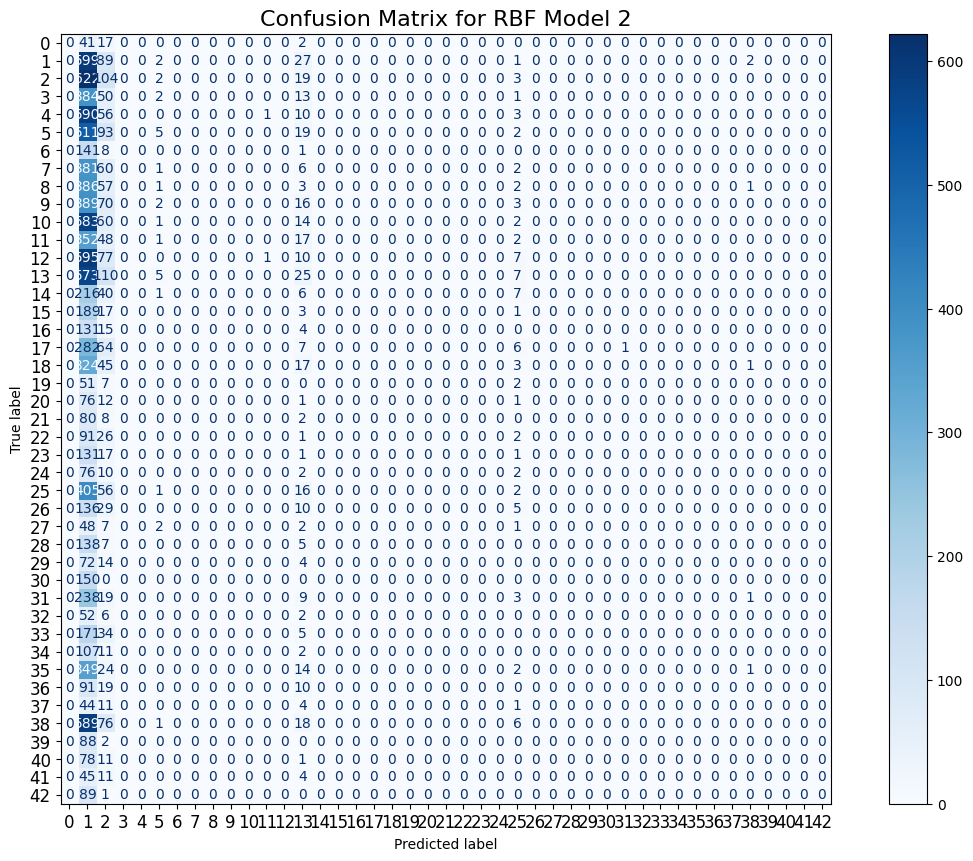

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred_encoded = model2.predict(X_test_scaled)  # Model tahminleri
y_pred = np.argmax(y_pred_encoded, axis=1)      # One-hot'dan sınıf etiketi olarak dönüştür
y_true = np.argmax(y_test_encoded, axis=1)      # Gerçek etiketleri one-hot'dan çıkar

# Karışıklık matrisi oluştur
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(15, 10))  # Daha uygun bir boyut seçildi
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # `ax` ile mevcut ekseni kullanıyoruz
plt.title("Confusion Matrix for RBF Model 2", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


RBF Modeli Model 2: Performans grafikleri

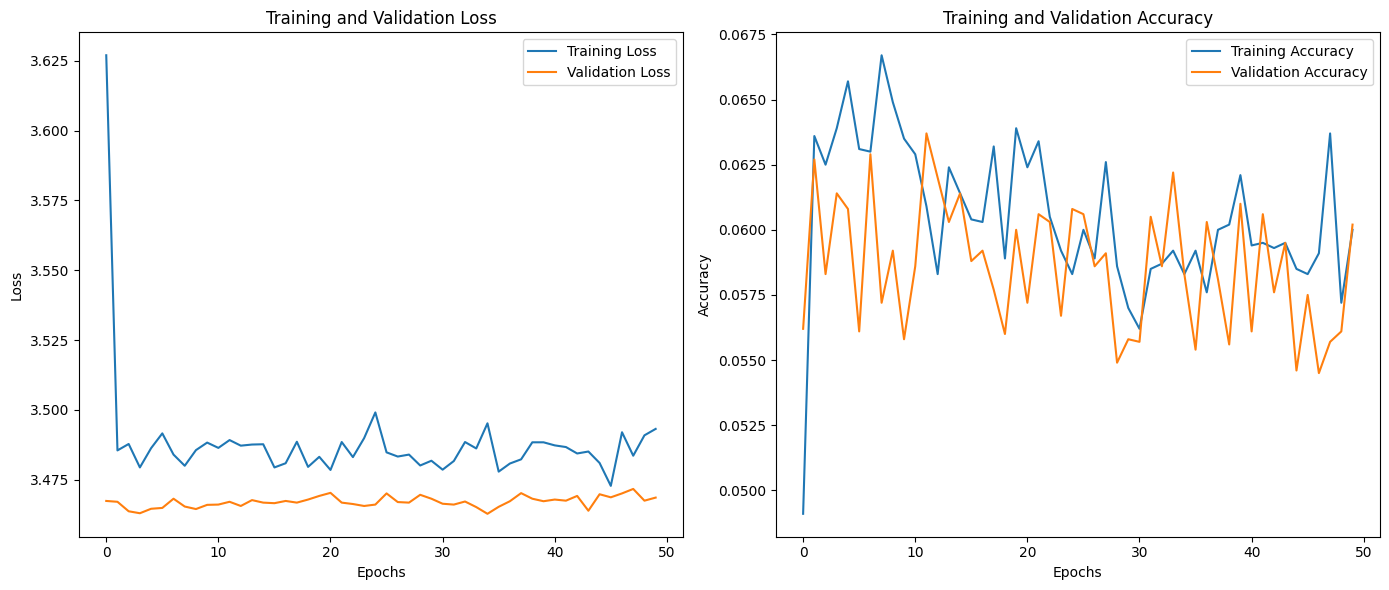

In [44]:
import matplotlib.pyplot as plt

# Modelin sonuçları
loss = [
    3.6270, 3.4855, 3.4878, 3.4794, 3.4863, 3.4916, 3.4840, 3.4800, 3.4856, 3.4883,
    3.4864, 3.4892, 3.4872, 3.4876, 3.4877, 3.4794, 3.4809, 3.4886, 3.4796, 3.4832,
    3.4785, 3.4885, 3.4831, 3.4899, 3.4991, 3.4848, 3.4833, 3.4840, 3.4801, 3.4818,
    3.4786, 3.4817, 3.4885, 3.4862, 3.4952, 3.4779, 3.4808, 3.4823, 3.4884, 3.4884,
    3.4873, 3.4867, 3.4844, 3.4851, 3.4810, 3.4728, 3.4920, 3.4836, 3.4909, 3.4932
]

val_loss = [
    3.4674, 3.4671, 3.4637, 3.4630, 3.4646, 3.4649, 3.4682, 3.4654, 3.4645, 3.4660,
    3.4661, 3.4671, 3.4656, 3.4677, 3.4668, 3.4666, 3.4674, 3.4668, 3.4679, 3.4692,
    3.4703, 3.4668, 3.4663, 3.4656, 3.4661, 3.4701, 3.4670, 3.4668, 3.4696, 3.4682,
    3.4664, 3.4661, 3.4672, 3.4652, 3.4628, 3.4653, 3.4673, 3.4702, 3.4682, 3.4673,
    3.4679, 3.4675, 3.4692, 3.4639, 3.4698, 3.4687, 3.4701, 3.4717, 3.4675, 3.4686
]

accuracy = [
    0.0491, 0.0636, 0.0625, 0.0639, 0.0657, 0.0631, 0.0630, 0.0667, 0.0649, 0.0635,
    0.0629, 0.0609, 0.0583, 0.0624, 0.0614, 0.0604, 0.0603, 0.0632, 0.0589, 0.0639,
    0.0624, 0.0634, 0.0605, 0.0592, 0.0583, 0.0600, 0.0589, 0.0626, 0.0586, 0.0570,
    0.0562, 0.0585, 0.0587, 0.0592, 0.0583, 0.0592, 0.0576, 0.0600, 0.0602, 0.0621,
    0.0594, 0.0595, 0.0593, 0.0595, 0.0585, 0.0583, 0.0591, 0.0637, 0.0572, 0.0600
]

val_accuracy = [
    0.0562, 0.0627, 0.0583, 0.0614, 0.0608, 0.0561, 0.0629, 0.0572, 0.0592, 0.0558,
    0.0586, 0.0637, 0.0620, 0.0603, 0.0614, 0.0588, 0.0592, 0.0577, 0.0560, 0.0600,
    0.0572, 0.0606, 0.0603, 0.0567, 0.0608, 0.0606, 0.0586, 0.0591, 0.0549, 0.0558,
    0.0557, 0.0605, 0.0586, 0.0622, 0.0583, 0.0554, 0.0603, 0.0581, 0.0556, 0.0610,
    0.0561, 0.0606, 0.0576, 0.0595, 0.0546, 0.0575, 0.0545, 0.0557, 0.0561, 0.0602
]

# Grafik oluşturma
plt.figure(figsize=(14, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


RBF Modeli Model 3:

In [24]:
# RBF Model 3
model3 = Sequential()
model3.add(Dense(20, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # Gaussian RBF
model3.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history3 = model3.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy3 = model3.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy3[1]}")


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0509 - loss: 3.6802 - val_accuracy: 0.0587 - val_loss: 3.5517
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0530 - loss: 3.5449 - val_accuracy: 0.0531 - val_loss: 3.4918
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0558 - loss: 3.5104 - val_accuracy: 0.0542 - val_loss: 3.4733
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0583 - loss: 3.4933 - val_accuracy: 0.0599 - val_loss: 3.4663
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0555 - loss: 3.5039 - val_accuracy: 0.0573 - val_loss: 3.4644
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0560 - loss: 3.4906 - val_accuracy: 0.0566 - val_loss: 3.4642
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0550 - loss: 3.4996 - val_accuracy: 0.0633 - val_loss: 3.4652
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0582 - loss: 3.4898 - val_accuracy: 0.

In [90]:
import numpy as np

# Tahmin edilen değerleri (y_pred) hesaplama
y_pred = model3.predict(X_test_scaled)  # Modelin test verileri üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Her sınıf için en yüksek olasılığa sahip etiketi alır

# Gerçek değerleri (y_true) işleme
y_true = np.argmax(y_test_encoded, axis=1)  # Gerçek etiketleri one-hot encoding'den çıkarır

# y_pred ve y_true çıktısı
print("Tahmin Edilen Değerler (y_pred):", y_pred_classes)
print("Gerçek Değerler (y_true):", y_true)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Tahmin Edilen Değerler (y_pred): [2 2 2 ... 2 2 2]
Gerçek Değerler (y_true): [16  1 38 ...  6  7 10]


RBF Modeli Model 3: Karışıklık Matrisi

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


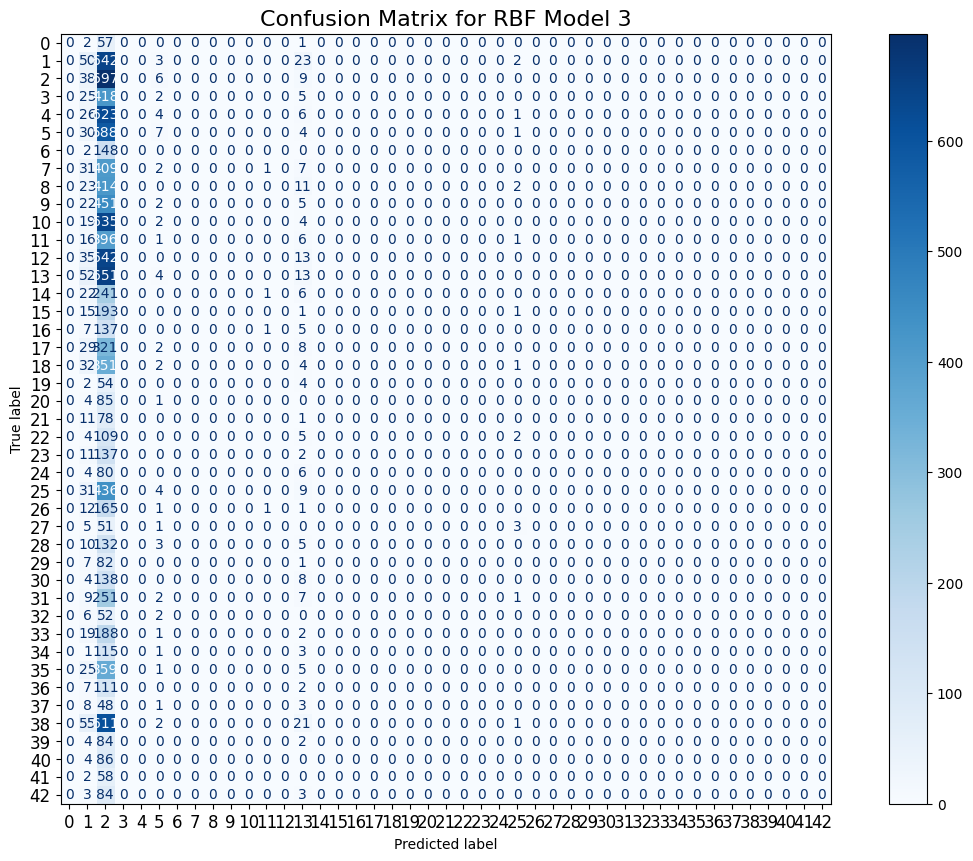

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred_encoded = model3.predict(X_test_scaled)  # Model tahminleri
y_pred = np.argmax(y_pred_encoded, axis=1)      # One-hot'dan sınıf etiketi olarak dönüştür
y_true = np.argmax(y_test_encoded, axis=1)      # Gerçek etiketleri one-hot'dan çıkar

# Karışıklık matrisi oluştur
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # Mevcut ekseni kullan
plt.title("Confusion Matrix for RBF Model 3", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


RBF Modeli Model 3: Performans grafikleri

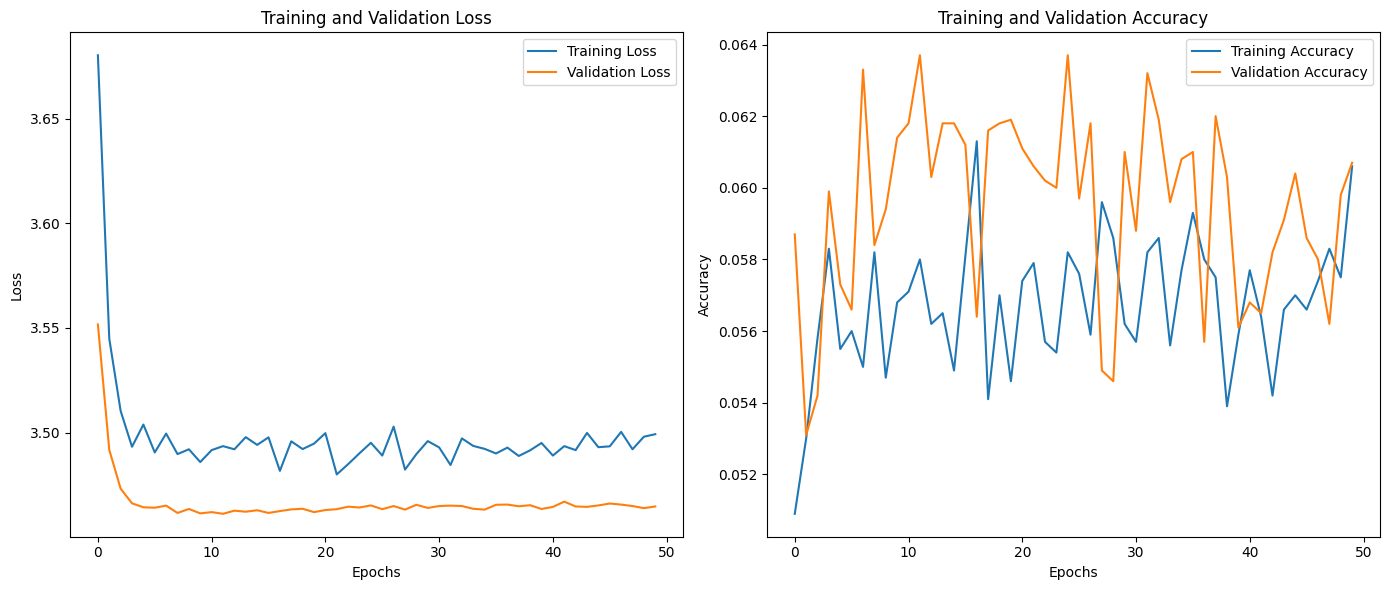

In [77]:
import matplotlib.pyplot as plt

# Modelin sonuçları
loss = [
    3.6802, 3.5449, 3.5104, 3.4933, 3.5039, 3.4906, 3.4996, 3.4898, 3.4921, 3.4860,
    3.4917, 3.4936, 3.4921, 3.4979, 3.4942, 3.4978, 3.4818, 3.4959, 3.4922, 3.4948,
    3.4998, 3.4801, 3.4850, 3.4902, 3.4952, 3.4891, 3.5029, 3.4824, 3.4898, 3.4960,
    3.4930, 3.4846, 3.4973, 3.4937, 3.4923, 3.4901, 3.4929, 3.4889, 3.4916, 3.4951,
    3.4891, 3.4936, 3.4917, 3.4999, 3.4931, 3.4935, 3.5004, 3.4921, 3.4981, 3.4993
]
val_loss = [
    3.5517, 3.4918, 3.4733, 3.4663, 3.4644, 3.4642, 3.4652, 3.4617, 3.4636, 3.4615,
    3.4621, 3.4613, 3.4628, 3.4623, 3.4630, 3.4617, 3.4626, 3.4634, 3.4637, 3.4621,
    3.4631, 3.4635, 3.4647, 3.4643, 3.4653, 3.4635, 3.4650, 3.4633, 3.4656, 3.4641,
    3.4650, 3.4652, 3.4650, 3.4637, 3.4633, 3.4656, 3.4657, 3.4649, 3.4654, 3.4636,
    3.4646, 3.4671, 3.4648, 3.4646, 3.4653, 3.4662, 3.4657, 3.4650, 3.4640, 3.4648
]
accuracy = [
    0.0509, 0.0530, 0.0558, 0.0583, 0.0555, 0.0560, 0.0550, 0.0582, 0.0547, 0.0568,
    0.0571, 0.0580, 0.0562, 0.0565, 0.0549, 0.0581, 0.0613, 0.0541, 0.0570, 0.0546,
    0.0574, 0.0579, 0.0557, 0.0554, 0.0582, 0.0576, 0.0559, 0.0596, 0.0586, 0.0562,
    0.0557, 0.0582, 0.0586, 0.0556, 0.0577, 0.0593, 0.0580, 0.0575, 0.0539, 0.0559,
    0.0577, 0.0564, 0.0542, 0.0566, 0.0570, 0.0566, 0.0574, 0.0583, 0.0575, 0.0606
]
val_accuracy = [
    0.0587, 0.0531, 0.0542, 0.0599, 0.0573, 0.0566, 0.0633, 0.0584, 0.0594, 0.0614,
    0.0618, 0.0637, 0.0603, 0.0618, 0.0618, 0.0612, 0.0564, 0.0616, 0.0618, 0.0619,
    0.0611, 0.0606, 0.0602, 0.0600, 0.0637, 0.0597, 0.0618, 0.0549, 0.0546, 0.0610,
    0.0588, 0.0632, 0.0619, 0.0596, 0.0608, 0.0610, 0.0557, 0.0620, 0.0603, 0.0561,
    0.0568, 0.0565, 0.0582, 0.0591, 0.0604, 0.0586, 0.0580, 0.0562, 0.0598, 0.0607
]

# Grafik oluşturma
plt.figure(figsize=(14, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


RBF Modeli Model 4:

In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import numpy as np

# Gaussian RBF aktivasyon fonksiyonu (TensorFlow kullanımı ile)
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # e^(-x^2)

# RBF Model 4
rbf_model3 = Sequential()

# Girdi katmanı + RBF katmanı
rbf_model3.add(Dense(128, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # 128 nöronlu RBF katmanı

# Ek Dense katmanları
rbf_model3.add(Dense(64, activation='relu'))
rbf_model3.add(Dense(32, activation='relu'))

# Çıkış katmanı
rbf_model3.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Sınıf sayısına göre çıkış

# Modeli derleme
rbf_model3.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Modeli eğitme
history_rbf3 = rbf_model3.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,  # Daha uzun bir eğitim süresi
    batch_size=128,  # Batch boyutu artırıldı
    verbose=1
)

# Model performansını değerlendirme
final_accuracy_rbf3 = rbf_model3.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Final Test Accuracy: {final_accuracy_rbf3[1]}")


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0713 - loss: 3.6124 - val_accuracy: 0.1570 - val_loss: 3.3822
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2061 - loss: 3.1745 - val_accuracy: 0.2457 - val_loss: 2.9606
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3613 - loss: 2.6671 - val_accuracy: 0.3846 - val_loss: 2.4805
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5225 - loss: 2.1382 - val_accuracy: 0.4685 - val_loss: 2.1358
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6095 - loss: 1.7252 - val_accuracy: 0.5245 - val_loss: 1.8429
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6833 - loss: 1.4022 - val_accuracy: 0.5758 - val_loss: 1.6488
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7381 - loss: 1.1736 - val_accuracy: 0.6017 - val_loss: 1.4966
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7978 - loss: 0.9683 - 

In [91]:
import numpy as np

# Tahmin edilen değerleri (y_pred) hesaplama
y_pred = rbf_model3.predict(X_test_scaled)  # Modelin test verileri üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Her sınıf için en yüksek olasılığa sahip etiketi alır

# Gerçek değerleri (y_true) işleme
y_true = y_test  # y_test zaten one-hot encoded değil, direkt gerçek sınıf etiketlerini içeriyor

# y_pred ve y_true çıktısı
print("Tahmin Edilen Değerler (y_pred):", y_pred_classes)
print("Gerçek Değerler (y_true):", y_true)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Tahmin Edilen Değerler (y_pred): [16  1 38 ... 15  7 10]
Gerçek Değerler (y_true): [16  1 38 ...  6  7 10]


RBF Modeli Model 4: Karışıklık Matriksi

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


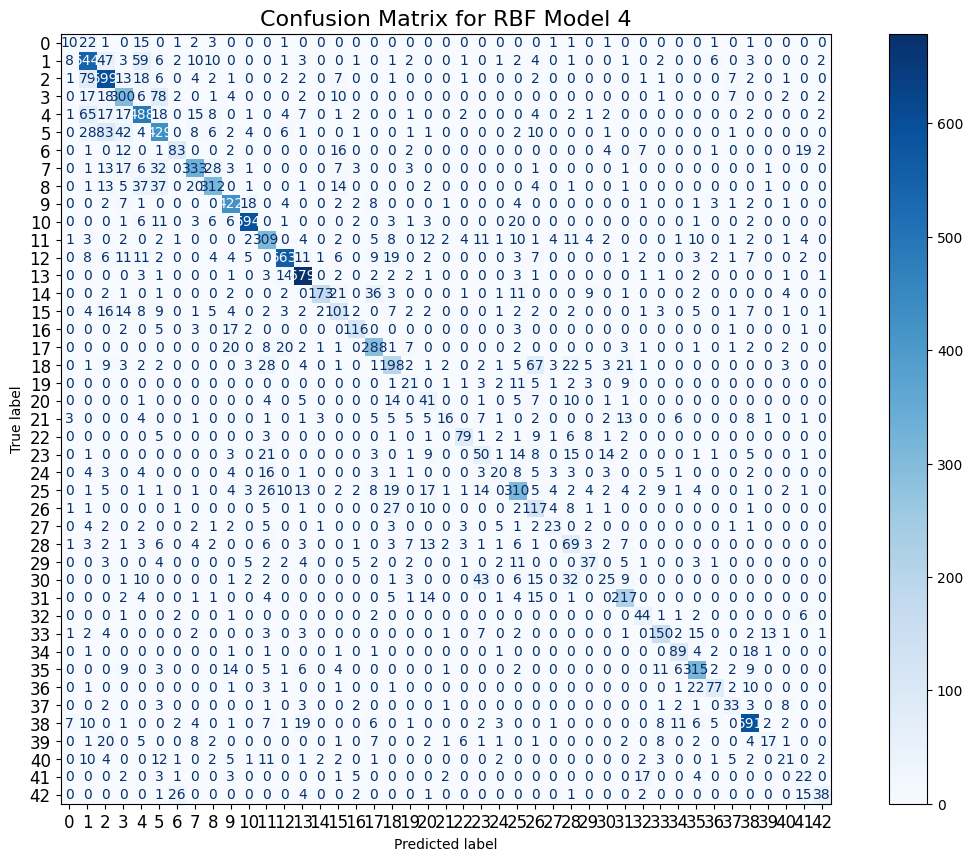

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred = np.argmax(rbf_model3.predict(X_test_scaled), axis=1)  # Model tahminleri
y_true = y_test  # Gerçek değerler

# Karışıklık matrisi oluştur
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # Mevcut ekseni kullan
plt.title("Confusion Matrix for RBF Model 4", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


RBF Modeli Model 4: Performans grafikleri

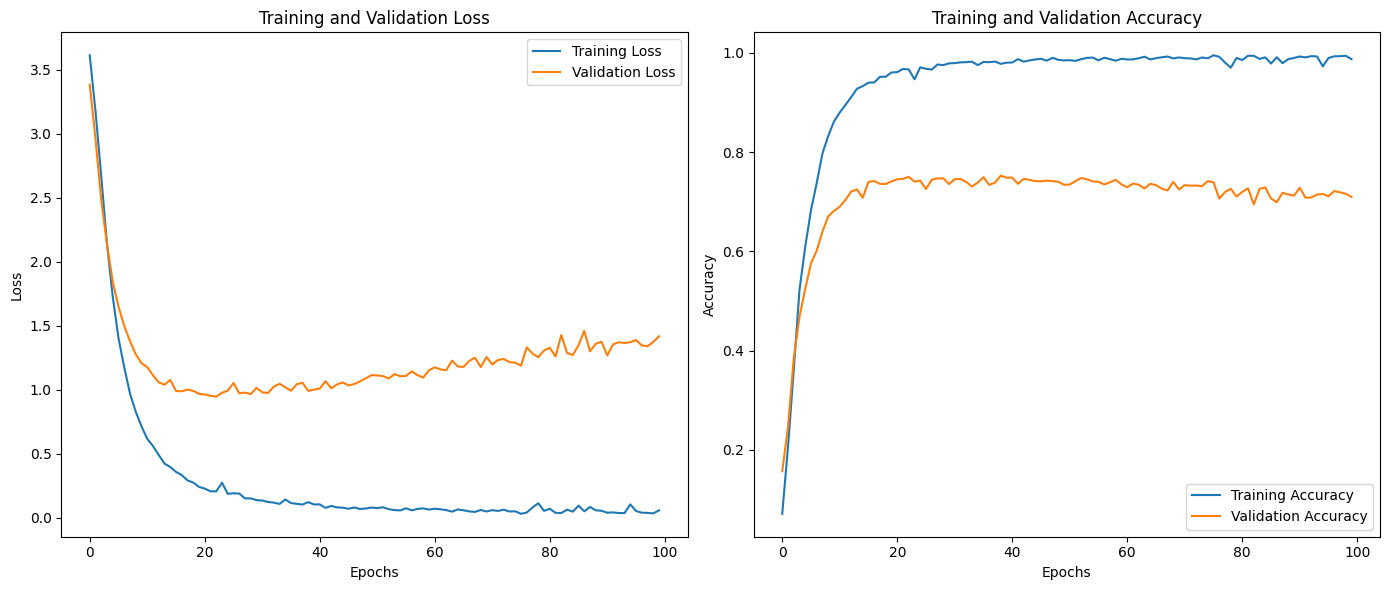

In [75]:
import matplotlib.pyplot as plt

# Modelin sonuçları
loss = [
    3.6124, 3.1745, 2.6671, 2.1382, 1.7252, 1.4022, 1.1736, 0.9683, 0.8271, 0.7128,
    0.6148, 0.5583, 0.4883, 0.4215, 0.3950, 0.3565, 0.3318, 0.2903, 0.2731, 0.2394,
    0.2260, 0.2048, 0.2043, 0.2722, 0.1849, 0.1898, 0.1871, 0.1493, 0.1497, 0.1362,
    0.1325, 0.1214, 0.1164, 0.1061, 0.1410, 0.1131, 0.1069, 0.1014, 0.1202, 0.1019,
    0.1028, 0.0753, 0.0905, 0.0789, 0.0770, 0.0685, 0.0783, 0.0668, 0.0707, 0.0776,
    0.0736, 0.0800, 0.0651, 0.0580, 0.0555, 0.0722, 0.0559, 0.0674, 0.0717, 0.0618,
    0.0690, 0.0644, 0.0578, 0.0460, 0.0632, 0.0564, 0.0478, 0.0440, 0.0587, 0.0472,
    0.0574, 0.0515, 0.0610, 0.0474, 0.0483, 0.0291, 0.0389, 0.0784, 0.1116, 0.0519,
    0.0686, 0.0368, 0.0352, 0.0616, 0.0459, 0.0928, 0.0485, 0.0825, 0.0564, 0.0527,
    0.0374, 0.0403, 0.0352, 0.0347, 0.1028, 0.0506, 0.0379, 0.0362, 0.0321, 0.0562
]
val_loss = [
    3.3822, 2.9606, 2.4805, 2.1358, 1.8429, 1.6488, 1.4966, 1.3788, 1.2761, 1.2062,
    1.1751, 1.1114, 1.0566, 1.0382, 1.0751, 0.9890, 0.9862, 0.9998, 0.9894, 0.9666,
    0.9616, 0.9517, 0.9451, 0.9750, 0.9912, 1.0513, 0.9710, 0.9761, 0.9645, 1.0136,
    0.9785, 0.9733, 1.0219, 1.0449, 1.0182, 0.9906, 1.0418, 1.0530, 0.9896, 0.9993,
    1.0080, 1.0655, 1.0102, 1.0397, 1.0561, 1.0322, 1.0430, 1.0641, 1.0875, 1.1127,
    1.1105, 1.1047, 1.0870, 1.1208, 1.1038, 1.1064, 1.1421, 1.1125, 1.0940, 1.1514,
    1.1735, 1.1575, 1.1514, 1.2258, 1.1809, 1.1766, 1.2243, 1.2482, 1.1757, 1.2547,
    1.1966, 1.2309, 1.2388, 1.2141, 1.2099, 1.1869, 1.3299, 1.2808, 1.2527, 1.3052,
    1.3265, 1.2586, 1.4264, 1.2868, 1.2699, 1.3465, 1.4582, 1.2989, 1.3581, 1.3738,
    1.2665, 1.3529, 1.3696, 1.3638, 1.3698, 1.3870, 1.3449, 1.3382, 1.3727, 1.4158
]
accuracy = [
    0.0713, 0.2061, 0.3613, 0.5225, 0.6095, 0.6833, 0.7381, 0.7978, 0.8326, 0.8618,
    0.8798, 0.8953, 0.9111, 0.9278, 0.9329, 0.9401, 0.9404, 0.9518, 0.9519, 0.9605,
    0.9612, 0.9677, 0.9667, 0.9467, 0.9709, 0.9680, 0.9663, 0.9766, 0.9753, 0.9789,
    0.9794, 0.9809, 0.9813, 0.9823, 0.9753, 0.9818, 0.9812, 0.9825, 0.9779, 0.9802,
    0.9806, 0.9874, 0.9823, 0.9849, 0.9868, 0.9880, 0.9843, 0.9901, 0.9860, 0.9848,
    0.9853, 0.9839, 0.9873, 0.9900, 0.9905, 0.9851, 0.9902, 0.9875, 0.9842, 0.9881,
    0.9867, 0.9869, 0.9892, 0.9923, 0.9868, 0.9893, 0.9911, 0.9926, 0.9889, 0.9908,
    0.9893, 0.9888, 0.9869, 0.9907, 0.9891, 0.9952, 0.9921, 0.9805, 0.9702, 0.9898,
    0.9856, 0.9942, 0.9941, 0.9878, 0.9910, 0.9785, 0.9912, 0.9793, 0.9873, 0.9898,
    0.9927, 0.9909, 0.9934, 0.9928, 0.9728, 0.9897, 0.9931, 0.9933, 0.9941, 0.9873
]
val_accuracy = [
    0.1570, 0.2457, 0.3846, 0.4685, 0.5245, 0.5758, 0.6017, 0.6403, 0.6707, 0.6816,
    0.6902, 0.7039, 0.7207, 0.7249, 0.7080, 0.7401, 0.7418, 0.7359, 0.7359, 0.7412,
    0.7451, 0.7462, 0.7502, 0.7405, 0.7426, 0.7257, 0.7445, 0.7470, 0.7473, 0.7358,
    0.7454, 0.7459, 0.7398, 0.7308, 0.7386, 0.7495, 0.7339, 0.7386, 0.7527, 0.7485,
    0.7487, 0.7362, 0.7462, 0.7442, 0.7416, 0.7412, 0.7426, 0.7416, 0.7403, 0.7342,
    0.7348, 0.7416, 0.7479, 0.7453, 0.7409, 0.7403, 0.7348, 0.7393, 0.7443, 0.7349,
    0.7292, 0.7367, 0.7342, 0.7268, 0.7363, 0.7334, 0.7264, 0.7228, 0.7401, 0.7248,
    0.7335, 0.7324, 0.7327, 0.7315, 0.7416, 0.7393, 0.7063, 0.7195, 0.7263, 0.7106,
    0.7199, 0.7272, 0.6945, 0.7260, 0.7288, 0.7067, 0.6990, 0.7181, 0.7147, 0.7124,
    0.7282, 0.7082, 0.7087, 0.7144, 0.7157, 0.7108, 0.7217, 0.7190, 0.7162, 0.7097
]

# Grafik oluşturma
plt.figure(figsize=(14, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


RBF Modeli Model 5:

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np

# Hedef değişkenleri one-hot encoding formatına dönüştürme
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# RBF Model 5
model_rbf4_new = Sequential([
    # İlk Katman: Daha fazla nöron ve ReLU aktivasyon
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),  # Aşırı öğrenmeyi önlemek için Dropout

    # Orta Katmanlar
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),

    # Çıkış Katmanı: Softmax aktivasyon
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Optimizatör ve Kayıp Fonksiyonu
optimizer = Adam(learning_rate=0.001)
model_rbf4_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Özeti
model_rbf4_new.summary()

# Modelin Eğitilmesi
history_rbf4_new = model_rbf4_new.fit(
    X_train_scaled, y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=50,  # Epoch sayısı düşük tutuldu
    batch_size=64,  # Daha dengeli öğrenme için artırıldı
    verbose=1
)

# Test Doğruluğu
final_accuracy = model_rbf4_new.evaluate(X_test_scaled, y_test_categorical, verbose=0)[1]
print(f"Final Test Accuracy: {final_accuracy}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,743,147 (6.65 MB)

 Trainable params: 1,743,147 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.2139 - loss: 3.3058 - val_accuracy: 0.4769 - val_loss: 1.8794
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.5389 - loss: 1.6738 - val_accuracy: 0.6227 - val_loss: 1.4613
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.6663 - loss: 1.2718 - val_accuracy: 0.6732 - val_loss: 1.4774
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7309 - loss: 1.0968 - val_accuracy: 0.7045 - val_loss: 1.3227
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7732 - loss: 0.9683 - val_accuracy: 0.7118 - val_loss: 1.2917
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7847 - loss: 0.9390 - val_accuracy: 0.7279 - val_loss: 1.3406
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.8078 - loss: 0.8791 - val_accuracy: 0.7219 - val_loss: 1.3582
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8044 - loss: 0.9071 - 

In [92]:
import numpy as np

# Tahmin edilen değerleri (y_pred) hesaplama
y_pred = model_rbf4_new.predict(X_test_scaled)  # Modelin test verileri üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Her sınıf için en yüksek olasılığa sahip etiketi alır

# Gerçek değerleri (y_true) işleme
y_true = np.argmax(y_test_categorical, axis=1)  # Gerçek etiketleri one-hot encoding'den çıkarır

# y_pred ve y_true çıktısı
print("Tahmin Edilen Değerler (y_pred):", y_pred_classes)
print("Gerçek Değerler (y_true):", y_true)


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Tahmin Edilen Değerler (y_pred): [16  1 38 ... 36 25 19]
Gerçek Değerler (y_true): [16  1 38 ...  6  7 10]


RBF Modeli Model 5: Karışıklık Matrisi

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


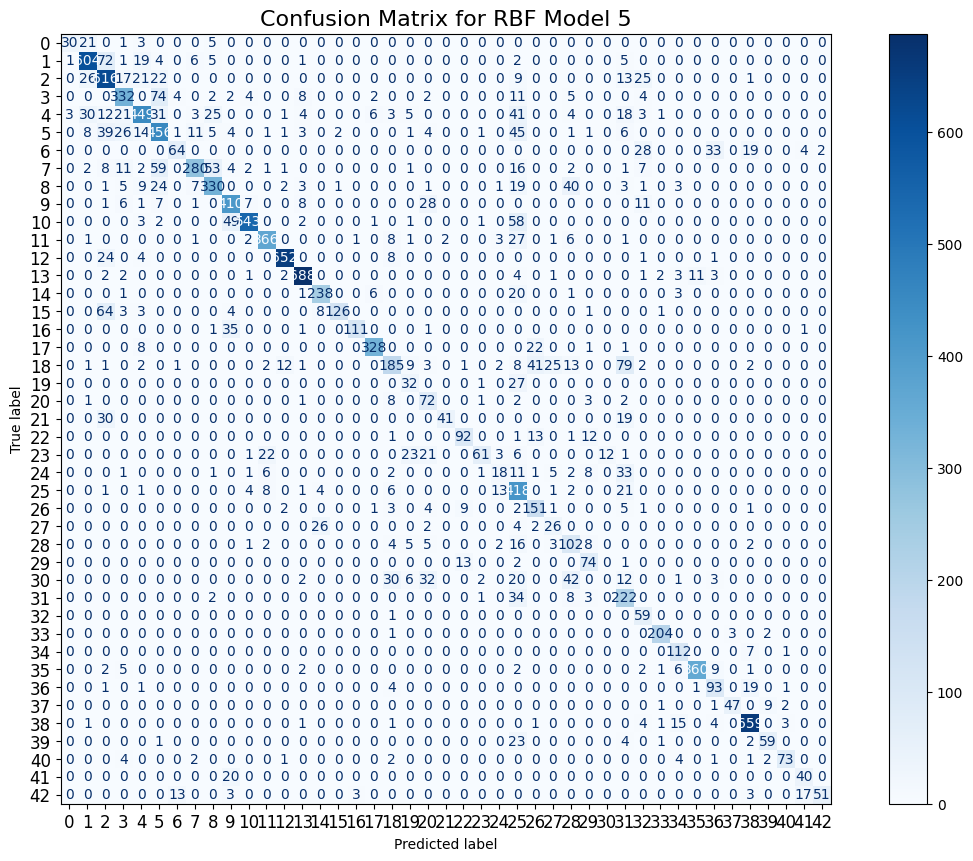

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred = np.argmax(model_rbf4_new.predict(X_test_scaled), axis=1)  # Model tahminleri
y_true = np.argmax(y_test_categorical, axis=1)  # Gerçek değerler

# Karışıklık matrisi oluştur
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # Mevcut ekseni kullan
plt.title("Confusion Matrix for RBF Model 5", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


RBF Modeli Model 5: Performans grafikleri

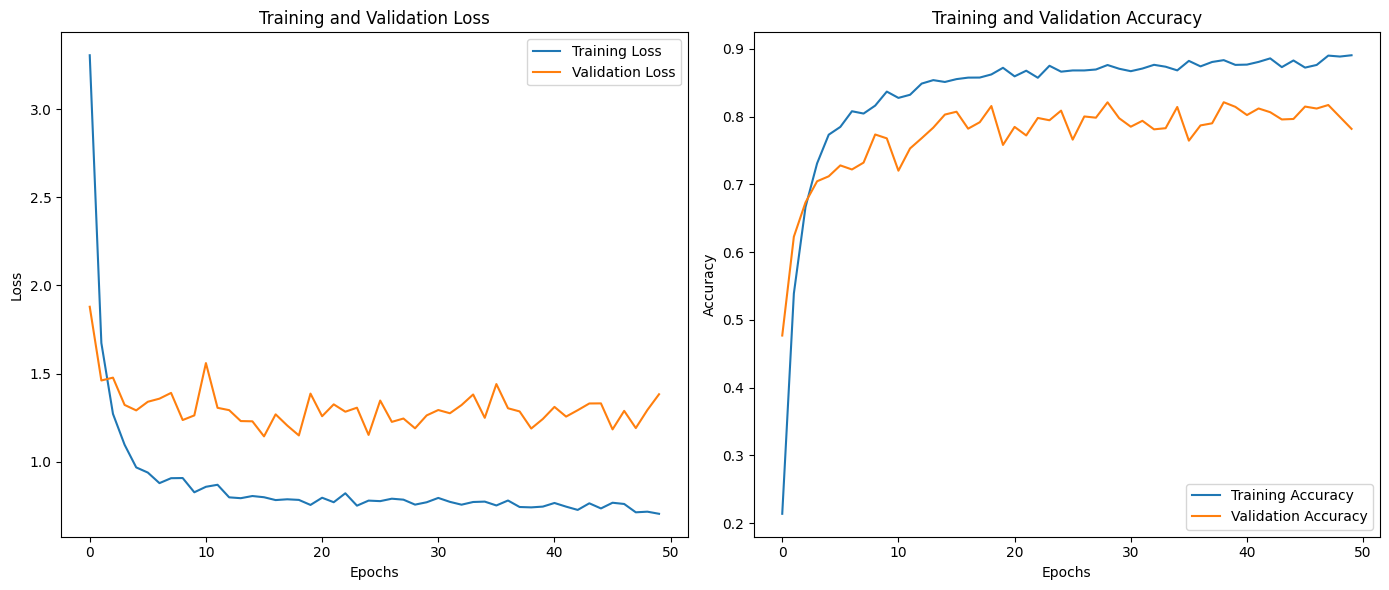

In [93]:
import matplotlib.pyplot as plt

# Modelin sonuçları
loss = [
    3.3058, 1.6738, 1.2718, 1.0968, 0.9683, 0.9390, 0.8791, 0.9071, 0.9080, 0.8272,
    0.8584, 0.8698, 0.7985, 0.7937, 0.8060, 0.7991, 0.7830, 0.7875, 0.7840, 0.7555,
    0.7963, 0.7708, 0.8215, 0.7513, 0.7800, 0.7770, 0.7908, 0.7854, 0.7572, 0.7706,
    0.7952, 0.7729, 0.7569, 0.7721, 0.7743, 0.7525, 0.7806, 0.7437, 0.7416, 0.7460,
    0.7666, 0.7458, 0.7272, 0.7647, 0.7356, 0.7679, 0.7609, 0.7136, 0.7172, 0.7052
]

val_loss = [
    1.8794, 1.4613, 1.4774, 1.3227, 1.2917, 1.3406, 1.3582, 1.3909, 1.2370, 1.2632,
    1.5600, 1.3063, 1.2930, 1.2311, 1.2297, 1.1443, 1.2693, 1.2058, 1.1496, 1.3869,
    1.2586, 1.3259, 1.2841, 1.3069, 1.1525, 1.3475, 1.2265, 1.2455, 1.1901, 1.2632,
    1.2938, 1.2754, 1.3219, 1.3819, 1.2495, 1.4410, 1.3037, 1.2858, 1.1888, 1.2430,
    1.3115, 1.2565, 1.2927, 1.3309, 1.3314, 1.1839, 1.2889, 1.1914, 1.2941, 1.3832
]

accuracy = [
    0.2139, 0.5389, 0.6663, 0.7309, 0.7732, 0.7847, 0.8078, 0.8044, 0.8161, 0.8368,
    0.8275, 0.8321, 0.8486, 0.8537, 0.8510, 0.8552, 0.8574, 0.8575, 0.8621, 0.8719,
    0.8593, 0.8676, 0.8572, 0.8749, 0.8662, 0.8680, 0.8680, 0.8694, 0.8760, 0.8705,
    0.8669, 0.8708, 0.8763, 0.8735, 0.8681, 0.8821, 0.8740, 0.8805, 0.8832, 0.8762,
    0.8766, 0.8806, 0.8858, 0.8729, 0.8827, 0.8722, 0.8761, 0.8899, 0.8885, 0.8904
]

val_accuracy = [
    0.4769, 0.6227, 0.6732, 0.7045, 0.7118, 0.7279, 0.7219, 0.7320, 0.7735, 0.7678,
    0.7201, 0.7529, 0.7680, 0.7836, 0.8029, 0.8071, 0.7821, 0.7916, 0.8155, 0.7581,
    0.7847, 0.7721, 0.7979, 0.7945, 0.8087, 0.7659, 0.8001, 0.7983, 0.8210, 0.7975,
    0.7850, 0.7937, 0.7811, 0.7828, 0.8141, 0.7644, 0.7869, 0.7900, 0.8211, 0.8143,
    0.8022, 0.8119, 0.8064, 0.7957, 0.7964, 0.8147, 0.8118, 0.8170, 0.7994, 0.7818
]

# Grafik oluşturma
plt.figure(figsize=(14, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
